# 多项式回归

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 产生数据

In [2]:
m = 100 # 样本数
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

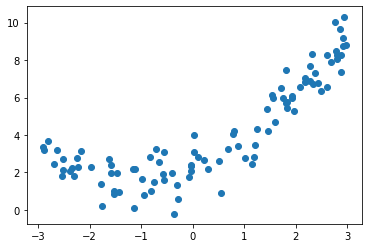

In [5]:
plt.scatter(X, y)

## 2. 预处理

构造一组$x^2$的特征

In [6]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [13]:
X.shape, X_poly.shape

((100, 1), (100, 2))

In [14]:
X[0], X_poly[0]

(array([1.83583218]), array([1.83583218, 3.3702798 ]))

## 3. 模型训练

由于已有特征$x, x^2$，可以直接采用线性模型，线性组合两者

In [16]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.22194341]), array([[1.02506192, 0.45281567]]))

[-3, 3, 0, 10]

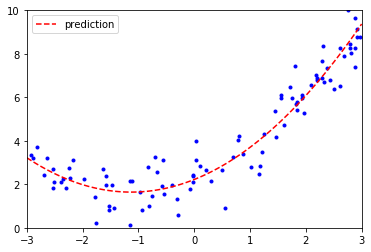

In [28]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
y_predict = lin_reg.predict(poly_features.transform(X_new))
plt.plot(X, y, 'b.')
plt.plot(X_new, y_predict, 'r--', label='prediction')
plt.legend()
plt.axis([-3, 3, 0, 10])

## 4. 学习曲线

描述训练模型在样本集和测试集上的表现效果

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [45]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), 'r-', linewidth=1, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=1, label='val')
#     plt.axis([0, 80, 0, 4])
    plt.legend()

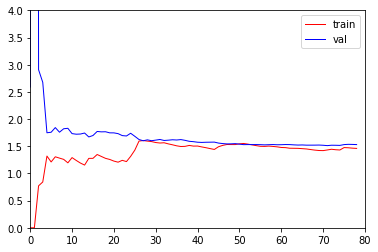

In [41]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

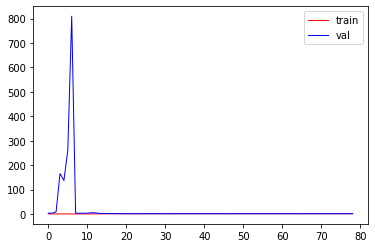

In [48]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
        ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
        ('sgd_reg', LinearRegression()),
))
plot_learning_curves(polynomial_regression, X, y)
# 为啥图这个鬼样子？懵了，数据太好？

## 5. 正则化

### 5.1 岭回归（Ridge regression）

也称Tikhonov正则化，添加正则项$\frac{\alpha}{2} \sum^n_{i=1} \theta^2_i$，L2范数的平方

在使用岭回归前，务必要将数据进行归一化，算法对数据尺度比较敏感（太多数正则化模型都是如此）

In [50]:
from sklearn.linear_model import Ridge

In [52]:
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.52487106]])

In [53]:
# 或采用梯度下降
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.50980145])

### 5.2 脊回归（Lasso regression）

也称Least Absolute Shrinkage, 或Selection Operator Regression, 添加正则项$\alpha \sum^n_{i=1} |\theta _i|$，使用L1范数

Lassor回归的重要特征是倾向于完全消除不重要特征的权重

In [61]:
from sklearn.linear_model import Lasso

In [62]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.49483457])

### 5.3 弹性网络（ElasticNet）

正则项为$r\alpha\sum^n_{i=1}|\theta_i| + \frac{1-r}{2}\alpha\sum^n_{i=1}\theta_i^2$

通过控制混合率$r$混合Ridge和Lasso，当$r=0$时，ElasticNet是Ridge回归，当$r=1$时，ElasticNet是Lasso回归

In [64]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.49204347])

### 5.4 早期停止法（Early Stopping）

当梯度下降在验证错误时达到最小值时就立即停止训练